# Final Project Assignment
---
Complete a Kaggle Store Sales getting started competition 
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/

## Problem statement
*"Forecasts are especially relevant to brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time"*  
**from Kaggle's competition description**  

In this assignment a dataset from Corporación Favorita, a large Ecuadorian-based grocery retailer is given. It is vital for the company to estimate accurately customer demand in order to maximize their income. A proper machine learning model may be a good solution.

## Problem solution


In [1]:
#import appropriate modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
#read data
import glob
dfs = dict()

for df_name in glob.glob('./Data/store-sales-time-series-forecasting/*.csv'):
        dfs[df_name.split('/')[-1].split('.')[0]] = pd.read_csv(df_name)

## Basic Data Preprocessing
As for the baseline model only 'date', 'store_nbr', 'family', 'onpromotion' features would be used.
- Being innately numerical 'onpromotion' and 'sales' columns are not changed.
- 'family' and 'store_nbr' are unordered purely categorical features. Therefore both of them are encoded into ordinals and then, being explicitly marked as categorical, given to the algorithm (see model performance comparison for different methods of cat features handling at https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py).
- In order to be more 'tangible' for the algorithm date feature is transformed into 3 separate columns: 'year', 'month' and 'day_of_month'. 'day_of_week' feature is also added as it is supposed to be obvious that sales depend on day of week (e.g. at weekends people buy more). All date features are innately ordered and thus not passed to the algorithm as explicitly categorical.

In [3]:
#merge dfs
local_dataset_size = dfs['train'].shape[0]
kaggle_test_size = dfs['test'].shape[0]
full_df = pd.concat([dfs['train'], dfs['test']], ignore_index=True)

In [4]:
#work with date features
full_df['date'] = pd.to_datetime(full_df['date'], format='%Y-%m-%d %H:%M:%S')
full_df['year'] = full_df['date'].dt.year
full_df['month'] = full_df['date'].dt.month
full_df['day_of_month'] = full_df['date'].dt.day
full_df['day_of_week'] = full_df['date'].dt.day_of_week

In [5]:
#encode categorical columns
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

features_to_encode = ['family']
full_df['family'] = enc.fit_transform(full_df[features_to_encode])

## Baseline Model

In [6]:
#define X and y
X = full_df.iloc[:local_dataset_size]
X_kaggle_test = full_df.iloc[-kaggle_test_size:]
y = X['sales']

used_cols = ['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day_of_month', 'day_of_week']
X = X[used_cols]
X_kaggle_test = X_kaggle_test[used_cols]

In [8]:
#split data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
train_idx, test_idx = list(tscv.split(X))[-1]

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [9]:
#define unordered categorical features
cols = list(X.columns)
unord_cat_cols = ['store_nbr', 'family']
cat_mask = [(col in unord_cat_cols) for col in cols]

In [10]:
#create baseline model
from sklearn.ensemble import HistGradientBoostingRegressor
hgbr = HistGradientBoostingRegressor(categorical_features=cat_mask, random_state=43)
hgbr.fit(X_train, y_train);

In [11]:
#test results
from sklearn.metrics import mean_squared_log_error

y_pred = hgbr.predict(X_test)
y_pred[y_pred < 0] = 0
print('RMSLE score:', round(mean_squared_log_error(y_test, y_pred, squared=False), ndigits=3))


RMSLE score: 1.069


In [12]:
#wrap up into a single test function
def baseline_test(full_df, used_cols=['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day_of_month', 'day_of_week'], unord_cat_cols=['store_nbr', 'family'], params={}, new_features=[], new_cat_features=[], rand_state=43):
    used_cols = used_cols + new_features
    unord_cat_cols = unord_cat_cols + new_cat_features
    #divide data
    X = full_df.iloc[:local_dataset_size]
    X_kaggle_test = full_df.iloc[-kaggle_test_size:]
    y = X['sales']
    #select proper columns
    X = X[used_cols]
    X_kaggle_test = X_kaggle_test[used_cols]
    #split data
    tscv = TimeSeriesSplit()
    train_idx, test_idx = list(tscv.split(X))[-1]
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    #define unordered categorical features
    cols = list(X.columns)
    cat_mask = [(col in unord_cat_cols) for col in cols]
    #create baseline model
    hgbr = HistGradientBoostingRegressor(categorical_features=cat_mask, random_state=rand_state, **params)
    hgbr.fit(X_train, y_train);
    #test results
    from sklearn.metrics import mean_squared_log_error
    y_pred = hgbr.predict(X_test)
    y_pred[y_pred < 0] = 0
    print('RMSLE score:', round(mean_squared_log_error(y_test, y_pred, squared=False), ndigits=3))
    return hgbr

## Exploratory analysis and feature generation

### Baseline again (to compare with)

In [13]:
baseline_test(full_df);

RMSLE score: 1.069


### "Oil"

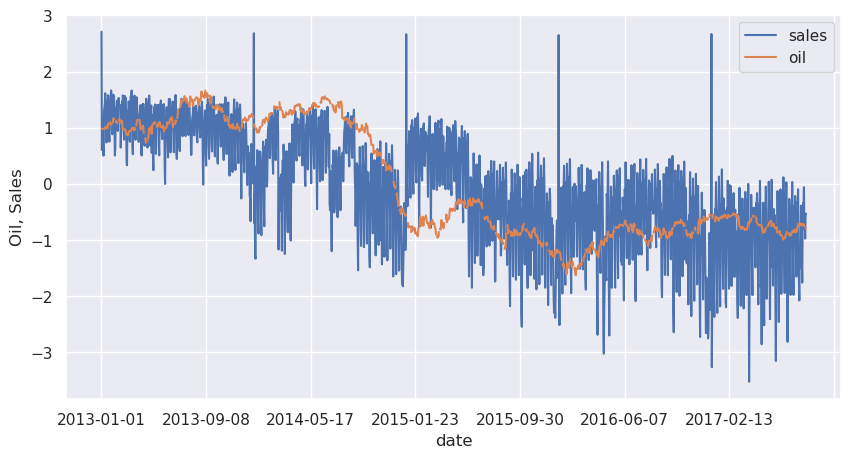

In [14]:
from sklearn.preprocessing import StandardScaler
oil = dfs['oil']
oil = oil.set_index('date')
df_temp = pd.DataFrame()
df_temp['sales'] = (-dfs['train'].groupby('date')['sales'].mean())
df_temp['oil'] = oil

df_temp[['sales', 'oil']] = StandardScaler().fit_transform(df_temp)
plt.figure(figsize=(10, 5))
df_temp['sales'].plot()
df_temp['oil'].plot()
plt.ylabel('Oil, Sales')
plt.legend();

In [15]:
date_oil = dfs['oil']
date_oil['date'] = pd.to_datetime(date_oil['date'], format='%Y-%m-%d %H:%M:%S')
full_df = pd.merge(full_df, date_oil, on='date', how='left')

In [16]:
baseline_test(full_df, new_features=['dcoilwtico']);

RMSLE score: 1.067


### "Cluster"

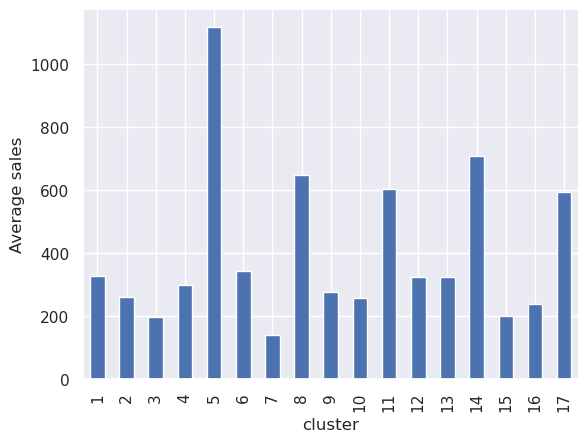

In [17]:
df_temp = pd.merge(dfs['train'], dfs['stores'], on='store_nbr', how='left')
df_temp.groupby('cluster')['sales'].mean().plot(kind='bar')
plt.ylabel('Average sales');

In [18]:
store_cluster = dfs['stores'][['store_nbr', 'cluster']]
full_df = pd.merge(full_df, store_cluster, on='store_nbr', how='left')

In [19]:
baseline_test(full_df, new_features=['cluster'], new_cat_features=['cluster']);

RMSLE score: 1.075


### "Type"

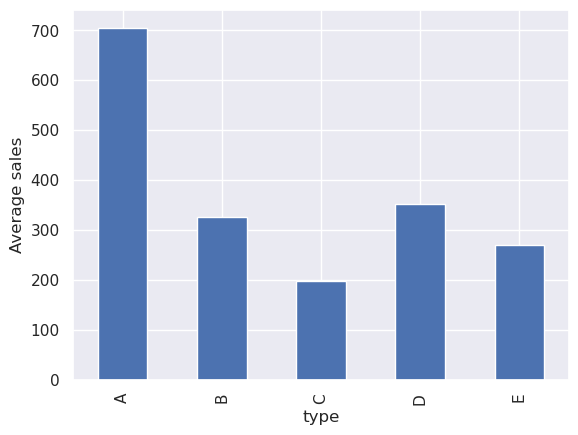

In [20]:
df_temp = pd.merge(dfs['train'], dfs['stores'], on='store_nbr', how='left')
df_temp.groupby('type')['sales'].mean().plot(kind='bar')
plt.ylabel('Average sales');

In [21]:
store_types = dfs['stores'][['store_nbr', 'type']]
full_df = pd.merge(full_df, store_types, on='store_nbr', how='left')

In [22]:
enc = OrdinalEncoder()
features_to_encode = ['type']
full_df['type'] = enc.fit_transform(full_df[features_to_encode])

In [23]:
baseline_test(full_df, new_features=['type'], new_cat_features=['type']);

RMSLE score: 1.089


*Commentary:*
At first glance sales seem to be dependent on features above. Still, the score barely changes. Thus, including them into the model seems to be poorly grounded.

## Hyperparameter tuning (for baseline)

Current case is a classical regression problem so metrics like MSE, RMSE, RMSLE would be a reasonable choice. Our data is unscaled so use of RMSLE as one that calculates relative error would be quite convinient. Moreover RMSLE is not affected much by outliers and is the one used in Kaggle competition so it is easy to compare our result with the others)  

Sales prediction is a time series problem - so simple 2Fold may be reasonable enough here.

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate' : [0.05, 0.1, 0.15],
    'max_iter' : [100, 200, 300],
    'max_leaf_nodes' : [31, 41, 51],
    'l2_regularization' : [0, 2]
}

def cv_gen(): #retruns last timeseries split 
    yield train_idx, test_idx

gs = GridSearchCV(estimator=hgbr, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, cv=cv_gen(), refit=False)

gs.fit(X, y)

best_params = gs.best_params_

Fitting 1 folds for each of 54 candidates, totalling 54 fits


In [25]:
best_params

{'l2_regularization': 2,
 'learning_rate': 0.15,
 'max_iter': 200,
 'max_leaf_nodes': 41}

In [26]:
best_hgbr = baseline_test(full_df, params=best_params)

RMSLE score: 0.97


## Kaggle prediction evaluation

In [27]:
#for Kaggle
y_kaggle_pred = best_hgbr.predict(X_kaggle_test)
y_kaggle_pred[y_kaggle_pred < 0] = 0
dfs['sample_submission']['sales'] = y_kaggle_pred
dfs['sample_submission'].to_csv('submission.csv', index=False)

## Wrap up and results analysis

Despite poor feature set, with proper categorical features handling and a good ML algorithm the baseline model occured to be quite felicitous.

Trials to break this result by adding new features did not succeed. Although being reasonable at first sight features like oil price, shop category andcluster did not improve the quality of prediction at all.

On the other hand, tuning the algorithm itself (mostly by increasing its scale) gave tangible results and impoved the accuracy significantly.

Overall the model showed quite satisfactory results (0.8 score on Kaggle), so in case better options are unavailable it can be used to help the company to estimate its bulk purchases.

Assignment completed by *Pavel Tikhonov*, *Evgeny Gurov* and *Arkadiy Vladimirov*